<a href="https://colab.research.google.com/github/STRMNGnwo/Masters-Thesis/blob/main/Srinivas_Masters_Thesis_TextBased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

### Added code to use specific versions of keras and tensorflow until the open issue on the keras stable diffusion implementation is resolved

In [ ]:
# Uninstall existing versions
!pip uninstall -y keras keras-core keras-cv tensorflow

# Install specific versions
!pip install keras==2.15.0 keras-core==0.1.7 keras-cv==0.9.0 tensorflow==2.15.1

# Restart the runtime to ensure the changes take effect
import os
os.kill(os.getpid(), 9)


Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled 

In [1]:
'''import keras
import keras_core
import keras_cv

#print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Keras Core version:", keras_core.__version__)
print("Keras CV version:", keras_cv.__version__)'''

Using TensorFlow backend
Keras version: 2.15.0
Keras Core version: 0.1.7
Keras CV version: 0.9.0


### The usual NLP plus libraries to access pre-trained models from HuggingFace, the openai api and CLIP

In [1]:
!pip install nltk
#used to perform semantic similarity analysis after evolutionary operators are used (to make sure they make sense)
!pip install sentence_transformers
!pip install language_tool_python

#to use the clip model as a fitness function
!pip install git+https://github.com/openai/CLIP.git
#to use the openai api to access the gpt 4o model
!pip install openai

!pip install transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Imports/ Downloads

In [2]:
#fundamental imports
import os
import sys
import random
import numpy as np
from PIL import Image
import torch

import nltk
from transformers import pipeline
import clip

In [3]:
#downloads that are necessary for the NLP based mutation and cross-over to occur

nltk.download('punkt')

#used to perform pos tagging (used to only mutate adjectives, verbs and nouns in mutation-synonym based and also contextual )
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

#used to obtain synonyms during mutation
nltk.download('words')
nltk.download('wordnet')

#used to ignore/remove stopwords during mutation
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import files
from google.colab import drive


drive.mount("/content/drive/")
sys.path.insert(0, '/content/drive/MyDrive/Masters-Thesis-Datasets/')

Mounted at /content/drive/


# Checking if GPU is available (and asking Colab to use it if it is)

In [5]:
if torch.cuda.is_available():
  DEVICE=torch.device("cuda")
  torch.cuda.get_device_name(0)
  print("GPU")

else:
  DEVICE="cpu"
  print("CPU")

GPU


# Importing and initialising a text to image stable diffusion model

Also a SpaCy English model

In [6]:
import time
import keras_cv
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend


In [7]:
sd_model = keras_cv.models.StableDiffusion(
    img_width=256, img_height=256, jit_compile=False
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [25]:
import spacy

# Loading the SpaCy model to perform Named Entity Recognition to get "descriptive" words
spacy_model = spacy.load("en_core_web_sm")

# Function to plot images

In [8]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

# Importing the dataset of Van Gogh paintings

These will serve as ground truth reference images and will also be provided to the LLM to get prompts

### Unzipping the dataset from drive

In [9]:
!unzip /content/drive/MyDrive/Masters-Thesis-Datasets/VanGogh.zip

Archive:  /content/drive/MyDrive/Masters-Thesis-Datasets/VanGogh.zip
  inflating: VanGoghPaintings.csv    
  inflating: VincentVanGogh/Arles/A Field of Yellow Flowers.jpg  
  inflating: VincentVanGogh/Arles/A L Arlesienne Madame Ginoux with Gloves and Umbre.jpg  
  inflating: VincentVanGogh/Arles/A Lane in the Public Garden at Arles.jpg  
  inflating: VincentVanGogh/Arles/A Lane near Arles.jpg  
  inflating: VincentVanGogh/Arles/A Pair of Leather Clogs.jpg  
  inflating: VincentVanGogh/Arles/A Pair of Shoes.jpg  
  inflating: VincentVanGogh/Arles/A Pork-Butcher s Shop Seen from a Window.jpg  
  inflating: VincentVanGogh/Arles/Almond Tree in Blossom.jpg  
  inflating: VincentVanGogh/Arles/Apricot Trees in Blossom 2.jpg  
  inflating: VincentVanGogh/Arles/Apricot Trees in Blossom.jpg  
  inflating: VincentVanGogh/Arles/Arles View from the Wheat Fields.jpg  
  inflating: VincentVanGogh/Arles/Avenue of Plane Trees near Arles Station.jpg  
  inflating: VincentVanGogh/Arles/Blossoming Almond

### Function to randomly choose an image from the dataset (or choose a specified image)

In [10]:
base_url="/content/VincentVanGogh/Watercolors"
def choose_image(image_path=None, return_image=True):

  #if no image path is specified choose a random image path from the Watercolors directory
  if image_path==None:
    image_paths = os.listdir(base_url)
    print("Num images:",len(image_paths))
    random_image_path = random.choice(image_paths)
    print("Chosen image path is: ",random_image_path)
    if return_image:
      return Image.open(os.path.join(base_url,random_image_path))
    else:
      return random_image_path

  else:
    if return_image:
      return Image.open(image_path)
    else:
      return image_path

Num images: 150
Chosen image path is:  Orchard in Blossom with Two Figures Spring.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


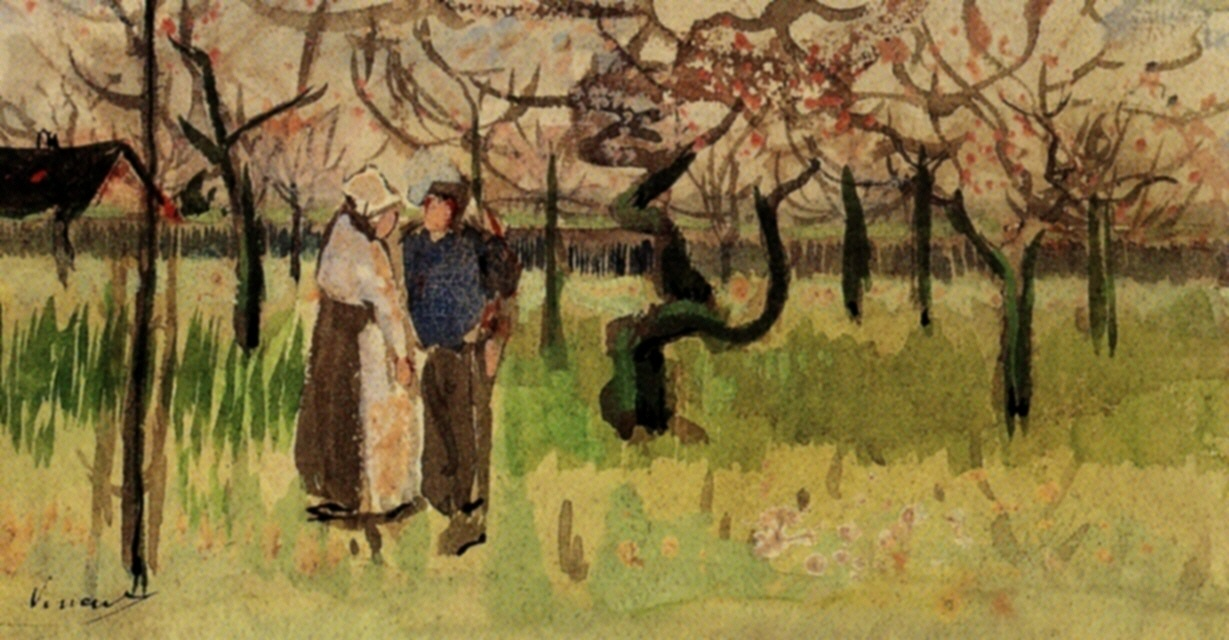

In [11]:
chosen_image=choose_image(image_path=None, return_image=True)
print(type(chosen_image))

display(chosen_image)

# LLM/API sections

### Establishing a connection to the OpenAI API

In [12]:
from google.colab import userdata
secret_key = userdata.get('OPENAI_APIKEY')

# OpenAI API Key
api_key = secret_key

import openai

client = openai.OpenAI(api_key=api_key)
#gpt-3.5-turbo-instruct has a price of US$0.50 /1M INPUT tokens and US$2.00 / 1M OUTPUT tokens

#PROBABLY BEST TO USE THE BELOW MODELS FOR TASKS: correcting grammar & sentences, providing image and getting captions back

#gpt-4o-mini has a price of US$0.150 / 1M input tokens AND US$0.600 / 1M OUTPUT tokens

#gpt-4o-mini-2024-07-18 has a price of US$0.150 / 1M input tokens AND US$0.600 / 1M OUTPUT tokens

### Function to send chosen image from dataset to LLM (via OpenAI API) and get list of descriptions (these will be used as initial population)

In [13]:
import base64
import requests

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def get_initial_descriptions(path_to_image,num_descriptions):

  BASE_PROMPT= f"Could you give me {num_descriptions} alt-text descriptions of the attached image, with each description describing the image?. Each description should vary in complexity (some like a 10-year old  wrote it, some like a professional artist wrote it, some like a writer wrote it etcetera) and length."
  image_path = path_to_image

  # Getting the base64 string
  base64_image = encode_image(image_path)

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4o-mini",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": BASE_PROMPT
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 500
  }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  print(response.json())

  return response

In [14]:
#descriptions_response=get_initial_descriptions(path_to_image="/content/VincentVanGogh/Watercolors/The Langlois Bridge at Arles.jpg",num_descriptions=10)

In [15]:
import re
from copy import deepcopy

'''
#descriptions_response_copy=deepcopy(descriptions_response)

desc_resp_json=descriptions_response.json()
#desc_resp_json["choices"][0]['message']['content']

# Regular expression pattern to extract descriptions, ignoring the initial text
pattern = re.compile(r'\d+\.\s+\*\*.*?\*\*:\s*(.*?)(?=\n\d+\.\s|\Z)', re.DOTALL)

# Remove the introductory part
intro_removed_text = re.sub(r'^Here are \d+ different alt-text descriptions for the image.*?\n\n', '', desc_resp_json["choices"][0]['message']['content'], flags=re.DOTALL).strip()

# Find all descriptions
descriptions = pattern.findall(intro_removed_text)

# Print the list of descriptions
for i, desc in enumerate(descriptions, 1):
    print(f"{desc.strip()}")

'''


'\n#descriptions_response_copy=deepcopy(descriptions_response)\n\ndesc_resp_json=descriptions_response.json()\n#desc_resp_json["choices"][0][\'message\'][\'content\']\n\n# Regular expression pattern to extract descriptions, ignoring the initial text\npattern = re.compile(r\'\\d+\\.\\s+\\*\\*.*?\\*\\*:\\s*(.*?)(?=\n\\d+\\.\\s|\\Z)\', re.DOTALL)\n\n# Remove the introductory part\nintro_removed_text = re.sub(r\'^Here are \\d+ different alt-text descriptions for the image.*?\n\n\', \'\', desc_resp_json["choices"][0][\'message\'][\'content\'], flags=re.DOTALL).strip()\n\n# Find all descriptions\ndescriptions = pattern.findall(intro_removed_text)\n\n# Print the list of descriptions\nfor i, desc in enumerate(descriptions, 1):\n    print(f"{desc.strip()}")\n\n'

### Hugging Face Instruct model - locally

Currently used for sentence correction

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto

#"microsoft/Phi-3-mini-4k-instruct"
#"Qwen/Qwen2-7B-Instruct"
llm_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    torch_dtype="auto",
    device_map="auto"
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [17]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
pipe = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
)

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
#function that should use the initialised microsoft 3B param instruct model locally to correct sentences (instead of making api calls)
def correct_sentences(sentences):
  child_sentences=[]
  for sentence in sentences:
    #sentence="Vibrant boats an orange beach a vivid blue sky their bold colors the ocean."
    prompt = f"Correct this sentence: {sentence}"
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }

    output = pipe(messages, **generation_args)
    child_sentences.append(output[0]['generated_text'])

  return child_sentences

### Grammar/sentence correction function- OpenAI API

In [19]:
def correct_sentences_api(sentences):
  sentence1,*sentence2=sentences
  response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
        {"role": "user", "content": f"Correct the following sentences so they become standard English and return each corrected sentence separated by a delimiter '|':\n1. '{sentence1}'\n2. '{sentence2}'"}
        ],
        max_tokens=len(sentence1) + len(sentence2) + 77,  # Ensure enough tokens for the response
        n=1,
        stop=None,
        temperature=0.5,
    )

  corrected_sentences = response.choices[0].message.content
  return corrected_sentences.split("|")

### Function to get "Descriptive words" about the chosen image.

These words can be used in a hopefully hugely beneficial mutation function (this should not be triggered often) that can append words like "painting, Van Gogh" etcetera to the end of a caption to make it more descriptive

In [ ]:
def get_descriptive_words(path_to_image, num_words):
  get_descriptives_prompt= f"Could you give me {num_words} words that are descriptive of this image?. Examples of such words are painting, watercolours"
  image_path = path_to_image

  # Getting the base64 string
  base64_image = encode_image(image_path)

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4o-mini",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": BASE_PROMPT
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 500
  }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  print(response.json())

  return response

### Function to get descriptive words using NER - Not used yet

In [ ]:
# List of image descriptions
descriptions = [
    "The image shows a beach scene with several colorful fishing boats.",
    "Fishing boats are resting on the sandy shore under a clear blue sky.",
    "Brightly painted boats are anchored on the golden beach with the ocean in the background.",
    "A vivid scene of boats on the shore with the horizon meeting the sea.",
    "Fishing vessels with colorful hulls on a sunny beach day.",
]


# Function to extract unique phrases
def extract_unique_phrases(descriptions):
    unique_phrases = set()
    for description in descriptions:
        doc = spacy_model(description)
        for chunk in doc.noun_chunks:
            unique_phrases.add(chunk.text.lower())
    return unique_phrases

# Extract unique phrases
unique_phrases = extract_unique_phrases(descriptions)

# Print the unique phrases
print(unique_phrases)

'''
# Extract unique entities
unique_entities = extract_unique_entities(descriptions)

# Print the unique entities
print(unique_entities)
'''

{'the shore', 'brightly painted boats', 'the golden beach', 'boats', 'the ocean', 'the horizon', 'colorful hulls', 'the image', 'the sandy shore', 'fishing vessels', 'the sea', 'a beach scene', 'several colorful fishing boats', 'a sunny beach day', 'fishing boats', 'a vivid scene', 'the background', 'a clear blue sky'}


'\n# Extract unique entities\nunique_entities = extract_unique_entities(descriptions)\n\n# Print the unique entities\nprint(unique_entities)\n'

### Testing the LLM that is accessed via API

In [ ]:
incorrect_sentence="On a golden beach , where the lazuline sea kisses the boats are on a beach succeeding to the ocean ."

print(correct_sentence(incorrect_sentence))

ChatCompletion(id='chatcmpl-9qeAf5bllMRIXEfMgQ27lGRmTBWuv', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='On a golden beach, where the lazuline sea kisses the shore, boats are anchored, succeeding to the ocean.', role='assistant', function_call=None, tool_calls=None))], created=1722334501, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_0f03d4f0ee', usage=CompletionUsage(completion_tokens=23, prompt_tokens=39, total_tokens=62))


# Evolutionary Computing Aspects

In [20]:
# trial generation of an image from initial population
reference_image_path="/content/VincentVanGogh/Watercolors/Fishing Boats on the Beach.jpg"

reference_image= Image.open(reference_image_path)

trial_prompt_1="Four colorful boats are on a beach next to the ocean."
trial_prompt_2="Vibrant boats rest on an orange beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings."

trial_prompt_3=" Vibrant boats with their bold colors sail on an orange beach under a vivid blue sky."

### Model Trial

198180272/198180272 [==============================] - 1s 0us/step


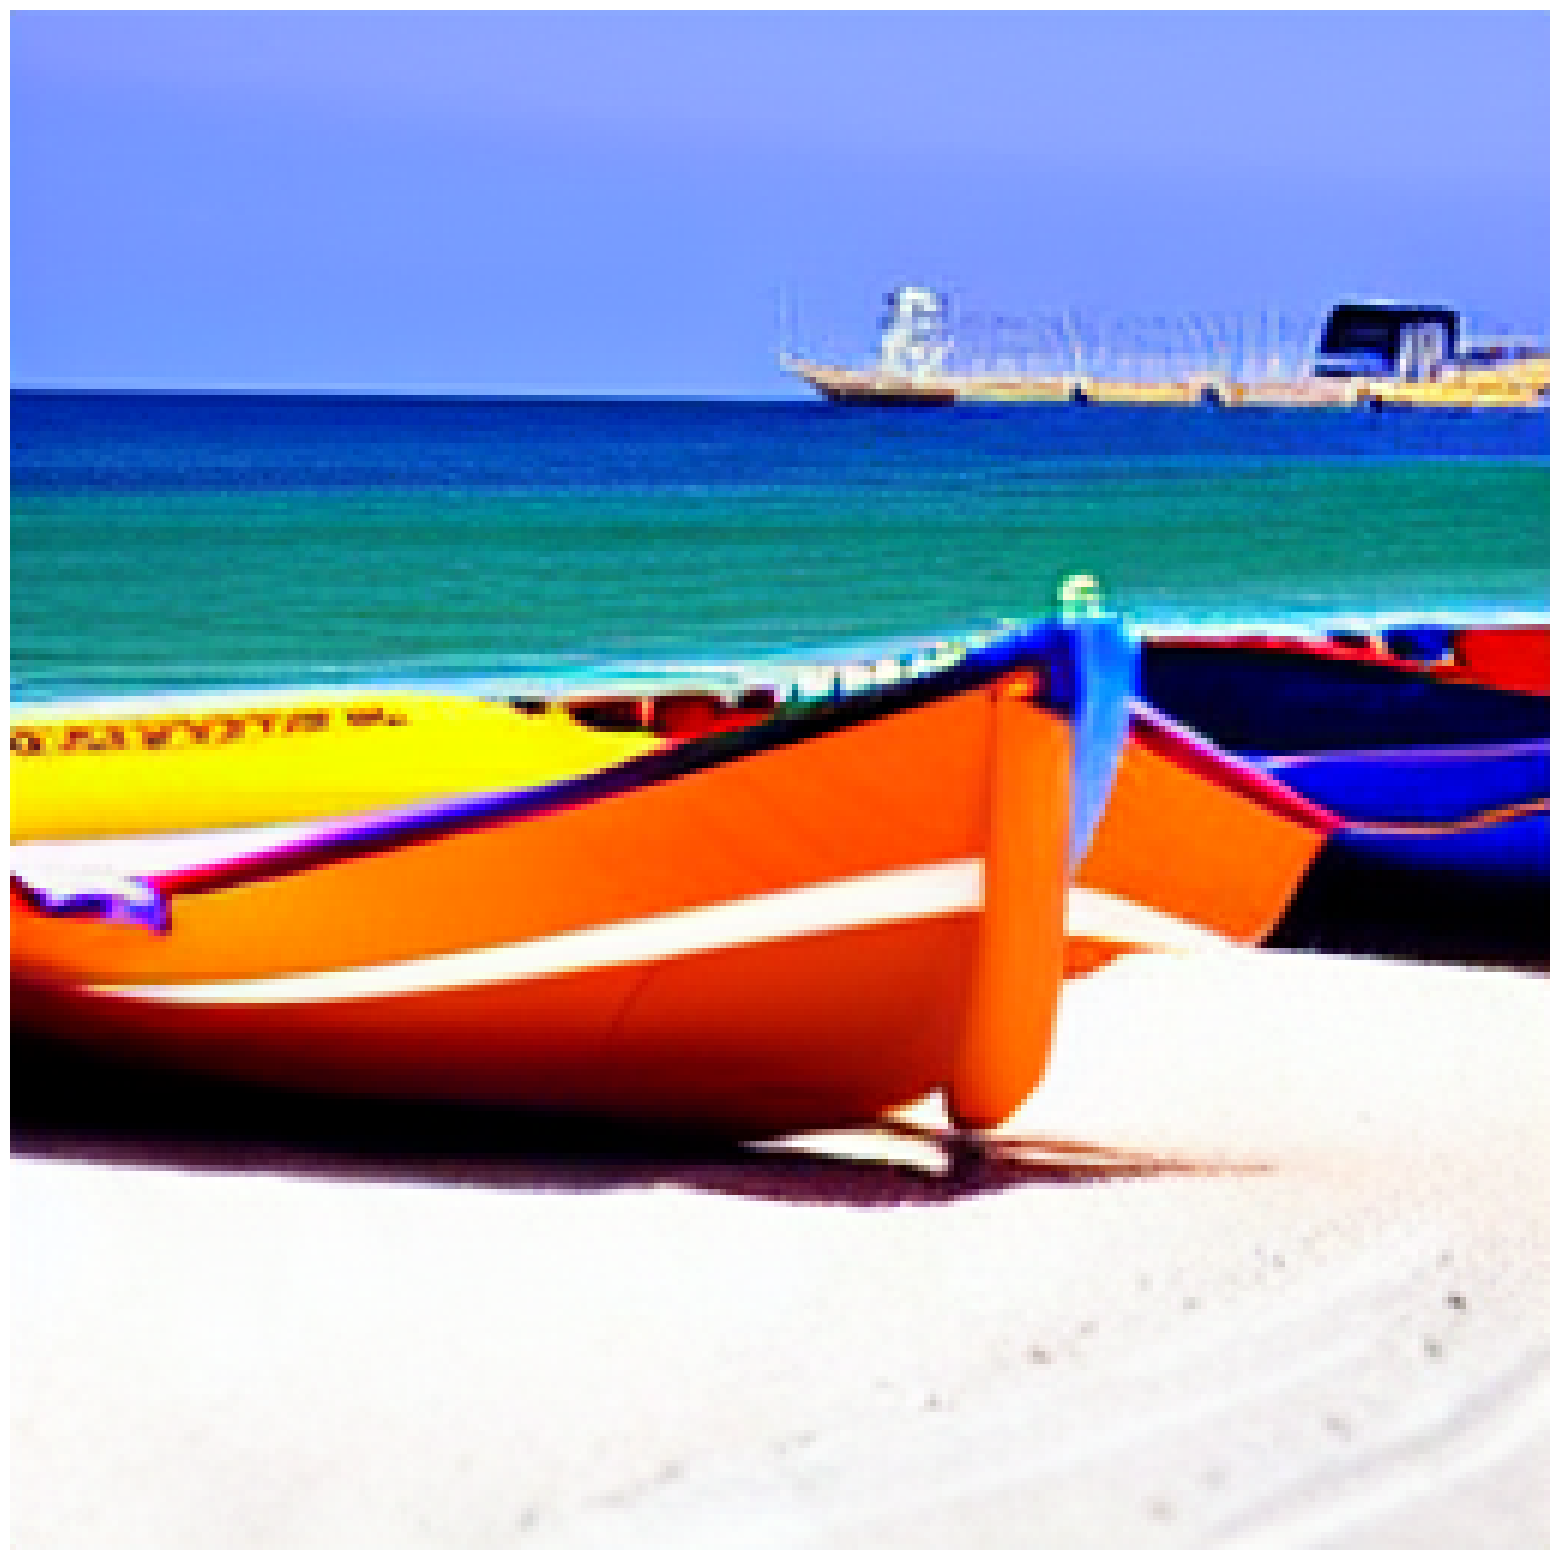

In [11]:
image_1 = sd_model.text_to_image(trial_prompt_3, batch_size=1)
plot_images(image_1)

In [ ]:
image_2 = sd_model.text_to_image("Vibrant boats rest on an Orange_River beach under a vivid blue sky , their bold colors creating a collide_with contrast with the instinctive surroundings .'", batch_size=1)
plot_images(image_2)

### Helper function to generate images for a prompt

In [21]:
def generate_image(individual):
  generated_image=model.text_to_image(individual["prompt"], batch_size=1)
  return generated_image

### NLP helper functions to aid mutation and cross-over

In [22]:
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag, word_tokenize
from nltk.chunk import ne_chunk
from sentence_transformers import SentenceTransformer, util
#import language_tool_python

stop_words = set(stopwords.words('english'))

#used to check if sentance after mutation and cross-over is grammatically correct and semantically similar
#tool = language_tool_python.LanguageTool('en-US')
transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
#used to check whether sentence is semantically similar after synonym mutation
def is_sentence_semantically_similar(original_sentence, mutated_sentence, threshold=0.8):
    embeddings = transformer_model.encode([original_sentence, mutated_sentence])
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()
    #print("Similarity is: "+str(similarity))
    return similarity >= threshold

#used in the mutation function that is based on synonyms
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)
    return list(synonyms)


#utilised in the cross-over function
def extract_phrases(sentence):
    words = word_tokenize(sentence)
    tagged = pos_tag(words)
    chunks = ne_chunk(tagged)
    phrases = []
    current_phrase = []
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            current_phrase.append(' '.join(c[0] for c in chunk))
        else:
            if current_phrase:
                phrases.append(' '.join(current_phrase))
                current_phrase = []
            phrases.append(chunk[0])
    if current_phrase:
        phrases.append(' '.join(current_phrase))
    return phrases

#utilised in the noun phrase based crossover
def extract_noun_phrases_spacy(text):
    # Process the text with spaCy
    doc = spacy_model(text)

    # Extract noun phrases
    phrases = [chunk.text for chunk in doc.noun_chunks]
    return phrases


sentence = "The quick brown fox jumps over the lazy dog near the Eiffel Tower."
phrases=extract_phrases(sentence)
print(phrases)
phrases_spacy = extract_noun_phrases_spacy(sentence)
print(phrases_spacy)

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'near', 'the', 'Eiffel Tower', '.']
['The quick brown fox', 'the lazy dog', 'the Eiffel Tower']


### Defining the SSIM fitness function to compare generated image with reference image

In [27]:
from skimage.metrics import structural_similarity as ssim

reference_image_resized = reference_image.resize((256, 256))
reference_image_pil=reference_image_resized
reference_image_np=np.asarray(reference_image_pil)

def fitness_function_ssim(individual):

  #basic score-> compare similarity between generated image and reference image
  #similarity determined by Structural Similarity Index which considers changes in structural information, luminance, and contrast
  # ssim value ranges from -1 to 1

  #removing the batch dimension from generated image (diffusion model outputs 4 dim batch-first, channel-last image)
  g_image=individual["image"]
  gen_image=g_image[0]
  ssim_index, _ = ssim(gen_image, reference_image_np, full=True,win_size=7, channel_axis=2)
  #print(f'SSIM: {ssim_index}')

  return ssim_index

'''
# testing out ssim
image_1_without_channel=image_1[0]
ssim_index1, _ = ssim(image_1_without_channel, reference_image_np, full=True, win_size=7, channel_axis=2)
print("Fitness of generated image 1, relative to actual image: ", ssim_index1)

image_2_without_channel=image_2[0]

ssim_index2, _ = ssim(image_2_without_channel, reference_image_np, full=True,win_size=7,channel_axis=2)
print("Fitness of generated image 2, relative to actual image: ",ssim_index2)'''

'\n# testing out ssim\nimage_1_without_channel=image_1[0]\nssim_index1, _ = ssim(image_1_without_channel, reference_image_np, full=True, win_size=7, channel_axis=2)\nprint("Fitness of generated image 1, relative to actual image: ", ssim_index1)\n\nimage_2_without_channel=image_2[0]\n\nssim_index2, _ = ssim(image_2_without_channel, reference_image_np, full=True,win_size=7,channel_axis=2)\nprint("Fitness of generated image 2, relative to actual image: ",ssim_index2)'

### Defining the CLIP based fitness function

In [28]:
clip_model, preprocess = clip.load("ViT-B/32", device=DEVICE)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.9MiB/s]


In [29]:
# Loading the summarization pipeline that is to be used to summarise descriptions if they're over 77 tokens
# this is required because CLIP only accepts a sequence of 77 tokens as input.
summarizer = pipeline("summarization")

#function that takes in a individual description/prompt and outputs a summarised version.
def summarize_description(description,max_length):
  summary = summarizer(description, max_length=max_length, min_length=25, do_sample=False)[0]['summary_text']
  return summary


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [30]:
#image converted to a tensor
def preprocess_image(image):
  image = preprocess(image).unsqueeze(0).to(DEVICE)
  #print("Pre-processed image type:",type(image))
  #print("pre-processed image dimensions,",image.shape)
  return image

def preprocess_caption(caption):
  #if the prompt/caption/description is more than 77 tokens long, pass it into the summarizer to get a shorter summary for CLIP to work on

  if len(caption.split()) > 77:
    caption = summarize_description(caption,max_length=77)

  token = clip.tokenize([caption]).to(DEVICE)
  return token

def get_image_embedding(image):
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
    return image_features

def get_text_embedding(caption):
    with torch.no_grad():
        text_features = clip_model.encode_text(caption)
    return text_features

img=preprocess_image(reference_image_pil)
print(img.type)

<built-in method type of Tensor object at 0x7dd4c934a160>


In [31]:
import torch.nn.functional as F

def compute_similarity(image_embedding, text_embedding):
    # Normalize the embeddings
    image_embedding = F.normalize(image_embedding, p=2, dim=-1)
    text_embedding = F.normalize(text_embedding, p=2, dim=-1)

    # Compute cosine similarity
    similarity = torch.matmul(text_embedding, image_embedding.T).item()
    return similarity


def fitness_function_clip(individual):
  individual_prompt=individual["prompt"]

  ref_image=preprocess_image(reference_image_pil)
  token = preprocess_caption(individual_prompt)

  # Get embeddings
  image_embedding = get_image_embedding(ref_image)
  text_embedding = get_text_embedding(token)

  # Compute similarity
  fitness_score = compute_similarity(image_embedding, text_embedding)

  return fitness_score

### Defining the mutation function

In [32]:
import random as rd
# The MUTATION operator

def synonym_mutate(individual, mutation_rate=0.3):
    sentence=individual["prompt"]
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)
    for i in range(len(words)):
        word, pos = pos_tags[i]
        if word.lower() not in stop_words and pos in  ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:  # Adjectives, Verbs and Nouns
            if random.random() < mutation_rate:
                synonyms = get_synonyms(word)
                if synonyms:
                    words[i] = random.choice(synonyms)
    #only return the mutated sentence if it is semantically similar to version pre-mutation (could help avoid boat becoming gravy holder and stuff like that )
    if is_sentence_semantically_similar(sentence,' '.join(words)):
      #print(' '.join(words)+" is similar to "+ sentence)
      return ' '.join(words)

    return sentence

# Contextual mutation can be used in later stages of the experimentation process, its not ready yet.

#TO DO: Vocabulary should be all words in the initial population of prompts (should I update vocabulary after every generation?).
# OR should Vocabulary be obtained by providing an image to a multi-modal LLM and ask it to provide a list of adjectives that can describe the image (artistic, painting, watercolour and stuff like that).
# Also for the replace bit-> should POS tag all words in prompt being mutated, POS tag vocabulary and then replace noun with noun, verb with verb etcetera.
'''
def contextual_mutation(individual, vocab, mutation_rate=0.3):
    sentence=individual["prompt"]
    words = word_tokenize(sentence)
    for i in range(len(words)):
        if random.random() < mutation_rate:
            #action = random.choice(['replace', 'add', 'remove'])
            action="replace"
            if action == 'replace':
                words[i] = random.choice(vocab)
            elif action == 'add':
                words.insert(i, random.choice(vocab))
            elif action == 'remove' and len(words) > 1:
                words.pop(i)
    return ' '.join(words)

'''

# trialling out both the synonym and context based mutations
sentence = "Vibrant boats rest on an orange beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings."

i1={"prompt":sentence}
mutated_sentence1 = synonym_mutate(i1)
print(f'Mutated Sentence 1 [Synonym based]: {mutated_sentence1}')
#print(f'Mutated Sentence 2 [Contextual]: {mutated_sentence2}')
#mutated_sentence2 = contextual_mutation(i1, vocab)


Mutated Sentence 1 [Synonym based]: Vibrant boats rest on an orange beach under a pictorial blue pitch , their bold_face colors creating a come_to contrast with the natural environ .


In [33]:
def mutate_population(population,mutation_rate):
  mutated_population=[]

  for individual in population:
    individual["prompt"]= synonym_mutate(individual,mutation_rate)
    mutated_population.append(individual)

  return mutated_population


### Defining the crossover function

In [40]:
#phrase based crossover
def phrase_based_crossover(parent1, parent2,use_llm_api=False):
  if use_llm_api:
    correction_function=correct_sentences_api
  else:
      correction_function=correct_sentences
  parent1_phrases = extract_phrases(parent1["prompt"])
  parent2_phrases = extract_phrases(parent2["prompt"])

  if len(parent1_phrases) > 1 and len(parent2_phrases) > 1:
      crossover_point1 = random.randint(1, len(parent1_phrases) - 1)
      crossover_point2 = random.randint(1, len(parent2_phrases) - 1)

      child1_phrases = parent1_phrases[:crossover_point1] + parent2_phrases[crossover_point2:]
      child2_phrases = parent2_phrases[:crossover_point2] + parent1_phrases[crossover_point1:]

      #ensure that the children are correct sentences/descriptions
      corrected_child_phrases=correction_function([' '.join(child1_phrases),' '.join(child2_phrases)])

      child1_corrected_phrase=corrected_child_phrases[0]
      child2_corrected_phrase=corrected_child_phrases[1]

      return child1_corrected_phrase, child2_corrected_phrase
  else:
      return parent1, parent2

# the cross over that seems more useful-> workflow involves cross-over + llm based correction
def noun_phrase_based_crossover(parent1, parent2,use_llm_api=True):
    if use_llm_api:
      correction_function=correct_sentences_api
    else:
      correction_function=correct_sentences

    parent1_phrases = extract_noun_phrases_spacy(parent1["prompt"])
    parent2_phrases = extract_noun_phrases_spacy(parent2["prompt"])

    if len(parent1_phrases) > 1 and len(parent2_phrases) > 1:
        crossover_point1 = random.randint(1, len(parent1_phrases) - 1)
        crossover_point2 = random.randint(1, len(parent2_phrases) - 1)

        child1_phrases = parent1_phrases[:crossover_point1] + parent2_phrases[crossover_point2:]
        child2_phrases = parent2_phrases[:crossover_point2] + parent1_phrases[crossover_point1:]

        print("Child 1 before being corrected: ",' '.join(child1_phrases))
        print("Child 2 before being corrected: ",' '.join(child2_phrases))
        #ensure that the children are correct sentences/descriptions
        corrected_child_phrases=correction_function([' '.join(child1_phrases),' '.join(child2_phrases)])

        child1_corrected_phrase=corrected_child_phrases[0]
        child2_corrected_phrase=corrected_child_phrases[1]

        print("Child 1 AFTER being corrected: ",child1_corrected_phrase)
        print("Child 2 AFTER being corrected: ",child2_corrected_phrase)

        return child1_corrected_phrase, child2_corrected_phrase
    else:
        return parent1["prompt"], parent2["prompt"]



# TO DO: Phrase based crossover can be fixed length (first one is what we're doing and another one can be "adaptive" n-word number- as n grows larger, allow for more phrases to be crossed over )
trial_prompt_1="Four colorful boats are on a beach next to the ocean."
trial_prompt_2="Vibrant boats rest on an orange beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings."

parent1 = {"prompt":trial_prompt_1}
parent2 = {"prompt":trial_prompt_2}

'''#trialling out the phrase based cross-over
child1, child2 = phrase_based_crossover(parent1, parent2, use_llm_api=False)
print(f'Phrase based Child 1: {child1}')
print(f'Phrase based Child 2: {child2}')'''

print("\n\n")
#trialling out the phrase based cross-over
nchild1, nchild2 = noun_phrase_based_crossover(parent1, parent2,use_llm_api=False)
print(f'noun Phrase based Child 1: {nchild1}')
print(f'noun Phrase based Child 2: {nchild2}')





Child 1 before being corrected:  Four colorful boats a beach a vivid blue sky their bold colors a striking contrast the natural surroundings
Child 2 before being corrected:  Vibrant boats an orange beach the ocean
Child 1 AFTER being corrected:   Four colorful boats are on a beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings.
Child 2 AFTER being corrected:   "Vibrant boats dot the orange beach at the ocean."
noun Phrase based Child 1:  Four colorful boats are on a beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings.
noun Phrase based Child 2:  "Vibrant boats dot the orange beach at the ocean."


In [41]:
# The CROSSOVER operator -generates kids until population size is back to normal (after selection process)
def crossover_population(population,cross_over_func,num_parents=2,POP_SIZE=20):

  needed_kids=POP_SIZE-len(population)
  print(f"Crossover needs to create {needed_kids} new samples")
  children=[]

  #using the specified cross over function
  if cross_over_func=="NOUN":
    cross_over_func=noun_phrase_based_crossover
  elif cross_over_func=="PHRASE":
    cross_over_func=phrase_based_crossover

  while len(children)<needed_kids:
    #choosing 2 parents from the population
    parent1,parent2=rd.sample(population,2)
    #actually doing the cross over
    child1prompt,child2prompt=cross_over_func(parent1, parent2,use_llm_api=False)

    if len(children) < needed_kids:
        child1 = {
            "prompt": child1prompt,
            "image": None,
            "fitness": -1000
        }

        children.append(child1)

    if len(children) < needed_kids:
        child2 = {
            "prompt": child2prompt,
            "image": None,
            "fitness": -1000
        }

        children.append(child2)


  return children

### Tournament Selection

In [ ]:
#fight function and tournament selection function
def fight(fight_participants):
  currWinner = fight_participants[0]
    #loop through participants and identify individual with highest fitness
  for i in range(1, len(fight_participants)):
      if fight_participants[i]["fitness"] > currWinner["fitness"]:
          currWinner = fight_participants[i]
  return currWinner

# Tournament selection function should return winners of the tournament
def tournament_selection(population, tournament_size,reference_image=reference_image):
    strongest_individuals=[]

    #making sure every text prompt is involved in the fight
    num_rounds=round(len(population)/tournament_size)
    for i in range(0, num_rounds):

        #giving some prompts a pass or a by if a fight doesn't have enough participants
        if (len(population)<tournament_size):
            for p in population:
                strongest_individuals.append(p)
            return strongest_individuals


        #randomly choosing tournament_size fighters to fight
        individuals_to_fight=rd.sample(population,tournament_size)

        #getting the winner of the fight and adding him to winners list
        strongest_individuals.append(fight(individuals_to_fight))

        #remove combatants from population (a prompt that has already "fought" won't fight again)
        for fighter in individuals_to_fight:
            population.remove(fighter)

    return strongest_individuals


### Defining the basic parameters of the Genetic Algorithm's evolutionary loop

In [ ]:
TOTAL_GENERATIONS=20
TOURNAMENT_SIZE=2
NUM_PARENTS=2
MUTATION_RATE=0.1
POP_SIZE=20

### Initialising the population of prompts and the image they should ideally generate

In [ ]:
def read_prompts_from_file(file_path,pop_size):
    with open(file_path, 'r') as file:
        prompts = [line.strip() for line in file if line.strip()]

    prompts_list=[]

    for idx,prompt in enumerate(prompts):
      if idx==pop_size:
        break
      print(f"prompt {idx}: "+ prompt)
      prompts_list.append(prompt.strip())

    return prompts_list

In [ ]:
def process_json(api_response):
  # Use the regex to find all matches
  matches = re.findall(r'\d+\.\s\*\*[^:]+:\*\*\s(.+?)(?=\n\d+\.|\Z)', api_response, re.DOTALL)

  # Print the results
  for match in matches:
      print(match.strip())

  return matches

In [ ]:
import re
import json
#initially population initialisation can be just reading in the text file of pre-defined prompts
def initialise_population(pop_size=5,image_path=None, read_from_file=False,make_api_call=True):
  print("Initialising population")
  #population is going to be a list of dict objects
  # population=[individual1:{"prompt":"a description of the image","fitness":fitness score, "image":generatedimage}, individual2]
  initial_population=[]

  print("Obtaining prompts")

  if read_from_file:
    # Reading in the prompts from text file (these will make up the initial population)
    prompts = read_prompts_from_file("/content/CaptionsMastersThesis-D1.txt",pop_size)

    print(f" Read in {len(prompts)} prompts")
    print("Creating representations")
    #initially setting fitness to a very low value for every prompt/text description
    for prompt in prompts:
      individual={}
      individual["prompt"]=prompt
      #individual["image"]=generate_image(individual)
      individual["fitness"]=-1000

      initial_population.append(individual)

#else use the LLM available via API to get initial descriptions
  elif make_api_call:
    print("Using the LLM to get initial descriptions")

    descriptions_response=get_initial_descriptions(path_to_image=image_path,num_descriptions=10)
    desc_resp_json=descriptions_response.json()
    #desc_resp_json["choices"][0]['message']['content']

    file_name = 'descriptions_response.json'

    # Open the file in write mode and dump the JSON data
    with open(file_name, 'w') as file:
      json.dump(desc_resp_json, file)

    print(f"JSON data has been written to {file_name}")

    # Find all descriptions
    descriptions = process_json(desc_resp_json["choices"][0]['message']['content'])#desc_resp_json["choices"][0]['message']['content']
    print("Number of descriptions:",len(descriptions))

    print(descriptions)

    for prompt in descriptions:
      individual={}
      individual["prompt"]=prompt
      #individual["image"]=generate_image(individual)
      individual["fitness"]=-1000
      initial_population.append(individual)

  else: #if api call has been made already

    print("Using LLM api call response stored in file")
    # Find all descriptions
    with open("descriptions_response.json", 'r') as file:
      data = json.load(file)
    descriptions = process_json(data["choices"][0]['message']['content'])#desc_resp_json["choices"][0]['message']['content']
    print("Number of descriptions:",len(descriptions))

    print(descriptions)

    for prompt in descriptions:
      individual={}
      individual["prompt"]=prompt
      #individual["image"]=generate_image(individual)
      individual["fitness"]=-1000
      initial_population.append(individual)


  return initial_population


### Running the loop

In [ ]:
#function that loops through population and evaluates/assigns fitness for each individual
def evaluate_population_fitness(population,use_ssim=False):

  fitness_population=population
  for index,individual in enumerate(fitness_population):
    #every x generations the existing fitness of the individual is multiplied by the ssim score
    if use_ssim:
      individual["fitness"]*=fitness_func_ssim(individual)
    #normally (for every generation) the fitness of an individual is calculated using clip score.
    else:
      individual["fitness"]=fitness_func_clip(individual)

  return fitness_population

In [ ]:
def print_top_individuals(population, top_n=5):
    # Sort the population by fitness in descending order
    sorted_population = sorted(population, key=lambda x: x["fitness"], reverse=True)
    top_individuals = sorted_population[:top_n]
    print(f"Top {top_n} individuals:")
    for idx, individual in enumerate(top_individuals):
        print(f"Rank {idx+1}: Fitness = {individual['fitness']}, Prompt = {individual['prompt']}")

In [ ]:
initial_population=initialise_population(pop_size=5,image_path="/content/VincentVanGogh/Watercolors/The Langlois Bridge at Arles.jpg",read_from_file=False,make_api_call=False)

#initialise population should take care of initial image generation for each prompt.
#Fitness still needs to be calculated

Initialising population
Obtaining prompts
Using LLM api call response stored in file
A big wooden bridge over water. There are people in a boat and some working by the river.
A bridge made of wood stretches over a river. People are in a boat, and there are workers nearby by the water’s edge.
A lively scene unfolds beneath a vibrant sky, where a sturdy wooden bridge looms over a shimmering river. Figures toil at the water’s edge, while a horse-drawn cart crosses above, evoking the rhythm of everyday life.
A dynamic composition centers on a wooden bridge, with laborers engaged in work by the riverbank. The interplay of color and form suggests a rich narrative of human endeavor.
This painting captures a significant moment in rural life, featuring a wooden bridge that connects two banks. Below it, laborers are seen working diligently along the river, while a cart navigates the bridge above, illustrating the intersection of nature and human activity.
Beneath a canvas of azure skies, a woode

In [ ]:
print(len(initial_population))

10


In [ ]:
import copy
population = copy.deepcopy(initial_population)

#Evolutionary loop
TOTAL_GENERATIONS=5
for generation in range(TOTAL_GENERATIONS):

  #evaluate fitness of entire population
  population=evaluate_population_fitness(population=population,use_ssim=False)
  print(f"---------------------------------------Generation {generation}---------------------------------------")
  print_top_individuals(population, top_n=3)

  # TO DO: have an elitism toggle to save a % high fitness individuals every generation to guarantee they make it to the next generation
  #tournament selection
  print("\nTOURNAMENT SELECTION:")
  print("Performing tournament selection on the population")
  print("Number of prompts in population: ",len(population))
  winners=tournament_selection(population=population,tournament_size=TOURNAMENT_SIZE)
  population=winners

  print("Number of prompts in population (After tournament): ",len(population))

  #crossover between winners to generate children which are then added to the population
  print("\nCROSSOVER PHASE:")
  print("Performing Cross-over on the population")
  crossed_over_children=crossover_population(population,NUM_PARENTS,POP_SIZE=len(initial_population,cross_over_func="NOUN")) #giving the function the population and the number of parents involved in a crossover
  population.extend(crossed_over_children)
  print("Number of prompts in population (After crossover): ",len(population))
  print("Cross-over phase completed")

  #mutation
  print("\nMUTATION PHASE:")
  print("Mutating population")
  population=mutate_population(population=population,mutation_rate=MUTATION_RATE)
  print("Mutation phase completed")

  #every 10 generations in, use the ssim score as a multiplier to the clip fitness
  #generate "new" images for current individual prompts in population
  if generation % 10 ==0:
    print("\nIMAGE GENERATION PHASE:")
    print("Generating images for prompts in population")
    for individual in population:
      individual["image"]=generate_image(individual)

  print(f"END OF GENERATION {generation}")

  #end of generation

#end of evolutionary loop


---------------------------------------Generation 0---------------------------------------
Top 3 individuals:
Rank 1: Fitness = 0.2610151171684265, Prompt = A dynamic composition centers on a wooden bridge, with laborers engaged in work by the riverbank. The interplay of color and form suggests a rich narrative of human endeavor.

Rank 2: Fitness = 0.251975417137146, Prompt = Beneath a canvas of azure skies, a wooden bridge stands as a vital artery for transport. Men and women, clad in humble attire, engage with the waterway, while a horse pulls a cart across the bridge, crafting a tableau of labor and harmony.

Rank 3: Fitness = 0.24020320177078247, Prompt = A lively scene unfolds beneath a vibrant sky, where a sturdy wooden bridge looms over a shimmering river. Figures toil at the water’s edge, while a horse-drawn cart crosses above, evoking the rhythm of everyday life.


TOURNAMENT SELECTION:
Performing tournament selection on the population
Number of prompts in population:  10
Numb

RuntimeError: Input Beneath a canvas of sapphire ski , a wooden bridge stands as a vital arteria for transport . Men and women , clad in humble attire , plight with the waterway , while a horse pulls a cart across a sturdy wooden bridge looms over a shimmer river . Figures toil at the water ’ s butt , while a horse-drawn go-cart crosses above , evoking the rhythm of everyday sprightliness . is too long for context length 77

In [ ]:
population=evaluate_population_fitness(population)
print_top_individuals(population,6)

Top 6 individuals:
Rank 1: Fitness = 0.15924215936367958, Prompt = 1.Four colorful boats are on a beach next to the are on a beach next to the ocean .
Rank 2: Fitness = 0.15229949724363998, Prompt = 1.Four beach next to the ocean .
Rank 3: Fitness = 0.12031175283159556, Prompt = 1.Four discolor gravy_boat brightly colored sauceboat with next to the sea .
Rank 4: Fitness = 0.11580600634952944, Prompt = 1.Four discolor boat brightly colored gravy_boat with red , a beach future to the ocean .
Rank 5: Fitness = 0.09489258762350782, Prompt = 1.Four beach Bolshevik , a beach next to the ocean .
Rank 6: Fitness = 0.07889953077395216, Prompt = 1.Four beach next gravy_boat with red , a beach next to the ocean .


#Experimental stuff /Old code

### Mechanism for cross-over (phrase based is fine):

### If a better cross-over mechanism is found and implemented, it can happen x% of the time to direct the evolution.

### Mechanism to correct grammar after cross-over -> DONE

### Mutation to add descriptive elements that were obtained initially (extra mutation)

### Mutation to remove a phrase randomly (Very low probability)

### To show "directed evolution"-> implement elitism.

Population of 10 individuals. Fitness is only done for image.

2 Fitness functions:

1-> CLIP based (comparing text to reference image in the embedding space) used initially. DONE

2-> Image based fitness function (SSIM) (every 10 generations) DONE

In [ ]:
'''!pip install transformers
from transformers import CLIPProcessor, CLIPModel

model_name = "openai/clip-vit-large-patch14-336"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)'''

In [ ]:
'''
#"Qwen/Qwen2-7B-Instruct" stuff after tokenizer


#sentence="Vibrant boats an orange beach a vivid blue sky their bold colors the ocean."
prompt = f"Correct this sentence: {sentence}"
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]'''